<a href="https://colab.research.google.com/github/Dongju5/QuantVerse/blob/main/%EC%A1%B0%ED%98%9C%EC%A7%84/%EB%AA%A8%EB%8D%B8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [85]:
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following NEW packages will be installed:
  fonts-nanum
0 upgraded, 1 newly installed, 0 to remove and 49 not upgraded.
Need to get 10.3 MB of archives.
After this operation, 34.1 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 fonts-nanum all 20200506-1 [10.3 MB]
Fetched 10.3 MB in 1s (12.1 MB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 78, <> line 1.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
Selecting previously unselected package fonts-nanum.
(Reading database ... 123630 files and direc

In [ ]:
import pandas as pd

# 데이터 로드
stock_data = pd.read_csv('kospi_200_stock_data.csv')  # 주가 데이터
financial_data = pd.read_csv('result_data.csv')  # 재무제표 데이터
kospi_200 = pd.read_csv('merged_kospi_200_corp_list.csv')  # 종목명, 시가총액, 산업 정보 포함

# 날짜 컬럼 이름 통일
financial_data.rename(columns={'공시날짜': '날짜'}, inplace=True)
# 날짜 변환: UNIX 타임스탬프 형식 처리
financial_data['날짜'] = pd.to_datetime(financial_data['날짜'], errors='coerce', format='%Y%m%d')


# 날짜 컬럼의 데이터 타입 변환 (datetime 형식으로 변환)
stock_data['날짜'] = pd.to_datetime(stock_data['날짜'], errors='coerce')
financial_data['날짜'] = pd.to_datetime(financial_data['날짜'], errors='coerce')

# 데이터 병합 (종목 코드와 날짜 기준)
merged_data = pd.merge(stock_data, financial_data, on=['stock_code', '날짜'], how='left')
merged_data = pd.merge(merged_data, kospi_200[['stock_code', 'industry']], on='stock_code', how='left')

# 날짜 오름차순으로 정렬
merged_data = merged_data.sort_values(by=['stock_code', '날짜'])

# 각 기업별로 forward fill 적용
merged_data = merged_data.groupby('stock_code').apply(lambda group: group.fillna(method='ffill'))

# groupby 후 원래 인덱스 복원
merged_data.reset_index(drop=True, inplace=True)

# 날짜 정렬 및 결측치 처리
merged_data = merged_data.sort_values(by=['stock_code', '날짜'])
merged_data = merged_data.groupby('stock_code').apply(lambda x: x.ffill().bfill()).infer_objects(copy=False)

#중복컬럼 제거
duplicate_columns = [col for col in merged_data.columns if '_x' in col or '_y' in col]

merged_data['corp_name'] = merged_data['corp_name_x']
merged_data.drop(columns=['corp_name_x', 'corp_name_y'], inplace=True)
merged_data['industry'] = merged_data['industry_x']
merged_data.drop(columns=['industry_x', 'industry_y'], inplace=True)



In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.impute import SimpleImputer

# 시가총액이 가장 높은 기업을 선택하기 위한 함수
def get_top_market_cap_companies(kospi_data):
    """
    산업군별 시가총액이 가장 높은 기업을 선택합니다.
    """
    top_companies = kospi_data.loc[kospi_data.groupby('industry')['MKTCAP'].idxmax()]
    return top_companies

# 산업별 가중치 정의
industry_weights = {
    '수익성 중심 산업군': {
        '산업군': ['음식료품', '의약품', '운수창고업', '화학'],
        '가중치': {'영업이익률': 0.4, '순이익률': 0.3, '매출액_증감률': 0.1, 'ROE': 0.2}
    },
    '안정성 중심 산업군': {
        '산업군': ['철강금속', '통신업', '전기가스업'],
        '가중치': {'부채비율': 0.4, '유동비율': 0.3, '고정비율': 0.2, '영업이익률': 0.1}
    },
    '성장성 중심 산업군': {
        '산업군': ['의료정밀', '비금속광물', '전기전자'],
        '가중치': {'매출액_증감률': 0.4, '영업이익_증감률': 0.3, 'ROE': 0.2, '부채비율': 0.1}
    },
    '혼합형 산업군': {
        '산업군': ['건설업', '운수장비', '기계', '기타제조업'],
        '가중치': {'영업이익률': 0.3, '순이익률': 0.2, '부채비율': 0.3, 'ROE': 0.2}
    },
    '소비재/서비스 중심 산업군': {
        '산업군': ['유통업', '섬유의복', '서비스업'],
        '가중치': {'매출총이익률': 0.4, 'ROE': 0.3, '유동비율': 0.2, '순이익률': 0.1}
    }
}

# 산업별 가중치를 계산하는 함수
def apply_weights(row, industry_weights):
    weighted_score = 0
    for group, details in industry_weights.items():
        if row['industry'] in details['산업군']:
            for key, weight in details['가중치'].items():
                if key in row and not pd.isna(row[key]):
                    weighted_score += row[key] * weight
    return weighted_score

# 데이터 로드
merged_data = pd.read_csv('merged_kospi_200_full_data.csv')
kospi_data = pd.read_csv('merged_kospi_200_corp_list.csv')  # 시가총액 정보가 포함된 기업 리스트

# 시가총액이 가장 높은 기업들의 데이터를 선택
top_companies = get_top_market_cap_companies(kospi_data)
selected_data = merged_data[merged_data['ISU_NM'].isin(top_companies['ISU_NM'])]
selected_data

# 가중치 계산 적용
selected_data['weighted_score'] = selected_data.apply(lambda row: apply_weights(row, industry_weights), axis=1)

# 타겟 변수 생성: 한 달 후 주가
selected_data['1_month_later_price'] = selected_data.groupby('ISU_CD')['TDD_CLSPRC'].shift(-20)

# 특성과 타겟 설정
features = ['weighted_score'] + list(set([key for details in industry_weights.values() for key in details['가중치'].keys()]))
X = selected_data[features]
y = selected_data['1_month_later_price']

# 결측치 및 무한값 처리
X.replace([np.inf, -np.inf], np.nan, inplace=True)
imputer = SimpleImputer(strategy='mean')
X = pd.DataFrame(imputer.fit_transform(X), columns=X.columns)
y = y.bfill().ffill()

# 데이터 분리
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 모델 훈련
model = RandomForestRegressor(random_state=42)
model.fit(X_train, y_train)

# 모델 평가
y_pred = model.predict(X_test)
print("모델 평가 결과:")
print(f"MAE: {mean_absolute_error(y_test, y_pred):.2f}")
print(f"MSE: {mean_squared_error(y_test, y_pred):.2f}")
print(f"R^2: {r2_score(y_test, y_pred):.2f}")


<ipython-input-1-788593997113>:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_data['weighted_score'] = selected_data.apply(lambda row: apply_weights(row, industry_weights), axis=1)
<ipython-input-1-788593997113>:63: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_data['1_month_later_price'] = selected_data.groupby('ISU_CD')['TDD_CLSPRC'].shift(-20)
<ipython-input-1-788593997113>:71: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats

모델 평가 결과:
MAE: 13699.90
MSE: 1624196876.08
R^2: 0.97


In [10]:
def predict_stock_price_on_date(stock_name, date, data,  industry_weights, trading_days=20):
    """
    특정 종목과 날짜를 기준으로 1개월 후 주가를 예측합니다.
    Args:
        stock_name (str): 종목명
        date (str): 예측 기준 날짜 (YYYY-MM-DD 형식)
        data (pd.DataFrame): 병합된 데이터프레임
        best_model (sklearn model): 최적화된 모델
        industry_weights (dict): 산업별 재무 가중치 설정
        trading_days (int): 예측 기간 (기본값 20일)
    Returns:
        dict: 예측 결과
    """
    # 날짜 및 종목 데이터 필터링
    stock_data = data[(data['ISU_NM'] == stock_name) & (data['BAS_DD'] <= date)].copy()
    if stock_data.empty:
        return {"error": f"종목명 '{stock_name}' 또는 날짜 '{date}'에 해당하는 데이터가 없습니다."}

    # 가장 가까운 날짜 데이터 가져오기
    stock_data = stock_data.sort_values(by='BAS_DD')
    latest_data = stock_data.iloc[-1]
    current_price = latest_data['TDD_CLSPRC']

    # 종목 데이터에 가중치 점수 계산 적용
    weighted_score = apply_weights(latest_data, industry_weights)

    # 재무지표 기반 등락률 계산
    expected_return = weighted_score * 0.01  # 가중치 점수 기반 등락률 계산 (비율로 변환)

    # 예측에 사용할 특성 만들기
    #feature = [weighted_score] + [latest_data[key] for key in features[1:]]
    #feature = np.array(feature).reshape(1, -1)

    # 최적화된 모델로 예측
    #predicted_price = model.predict(feature)[0]

    # 1개월 뒤 주가 계산 (단, 이는 주가 예측에만 영향을 미침)
    growth_factor = (1 + expected_return) ** (trading_days / 252)
    predicted_price_with_growth = current_price * growth_factor

    # 결과 반환
    return {
        "종목명": stock_name,
        "예측 기준 날짜": date,
        "현재 주가": current_price,
        "재무지표 등락률": expected_return,
        "1개월 후 예상 주가": predicted_price_with_growth
    }

# 특정 종목과 날짜로 예측 실행
result = predict_stock_price_on_date("삼성전자", "2024-08-15",selected_data, industry_weights)
print(result)

{'종목명': '삼성전자', '예측 기준 날짜': '2024-08-15', '현재 주가': 77200, '재무지표 등락률': 0.218051829478, '1개월 후 예상 주가': 78418.07387546373}


In [69]:
# 피처 중요도 추출
feature_importances = model.feature_importances_

# 중요도에 따른 피처 정렬
sorted_idx = np.argsort(feature_importances)[::-1]

# 중요 피처 출력
print("Top 10 Important Features:")
for idx in sorted_idx[:10]:
    print(f"{X.columns[idx]}: {feature_importances[idx]:.4f}")


Top 10 Important Features:
고정비율: 0.2029
매출총이익률: 0.1951
유동비율: 0.1882
weighted_score: 0.1433
순이익률: 0.0926
부채비율: 0.0677
영업이익률: 0.0523
매출액_증감률: 0.0251
ROE: 0.0244
영업이익_증감률: 0.0083


In [15]:
# 특정 종목과 날짜로 예측 실행
result = predict_stock_price_on_date("삼성전자", "2024-08-14", selected_data, industry_weights)
print(result)
result = predict_stock_price_on_date("NAVER", "2024-08-14", selected_data, industry_weights)
print(result)
result = predict_stock_price_on_date("현대건설", "2024-08-14", selected_data, industry_weights)
print(result)
result = predict_stock_price_on_date("현대자동차", "2024-08-14", selected_data, industry_weights)
print(result)
result = predict_stock_price_on_date("LG화학", "2024-08-14", selected_data, industry_weights)
print(result)
result = predict_stock_price_on_date("삼성물산", "2024-08-14", selected_data, industry_weights)
print(result)



{'종목명': '삼성전자', '예측 기준 날짜': '2024-08-14', '현재 주가': 77200, '재무지표 등락률': 0.218051829478, '1개월 후 예상 주가': 78418.07387546373}
{'종목명': 'NAVER', '예측 기준 날짜': '2024-08-14', '현재 주가': 157300, '재무지표 등락률': 0.27982693721900004, '1개월 후 예상 주가': 160410.4990054758}
{'종목명': '현대건설', '예측 기준 날짜': '2024-08-14', '현재 주가': 30800, '재무지표 등락률': 0.379594450565, '1개월 후 예상 주가': 31596.727196606127}
{'종목명': '현대자동차', '예측 기준 날짜': '2024-08-14', '현재 주가': 241000, '재무지표 등락률': 0.593191194959, '1개월 후 예상 주가': 250074.86919643614}
{'종목명': 'LG화학', '예측 기준 날짜': '2024-08-14', '현재 주가': 296000, '재무지표 등락률': -0.005524411207000003, '1개월 후 예상 주가': 295869.8889813353}
{'종목명': '삼성물산', '예측 기준 날짜': '2024-08-14', '현재 주가': 139500, '재무지표 등락률': 0.338921389635, '1개월 후 예상 주가': 142769.07132634058}


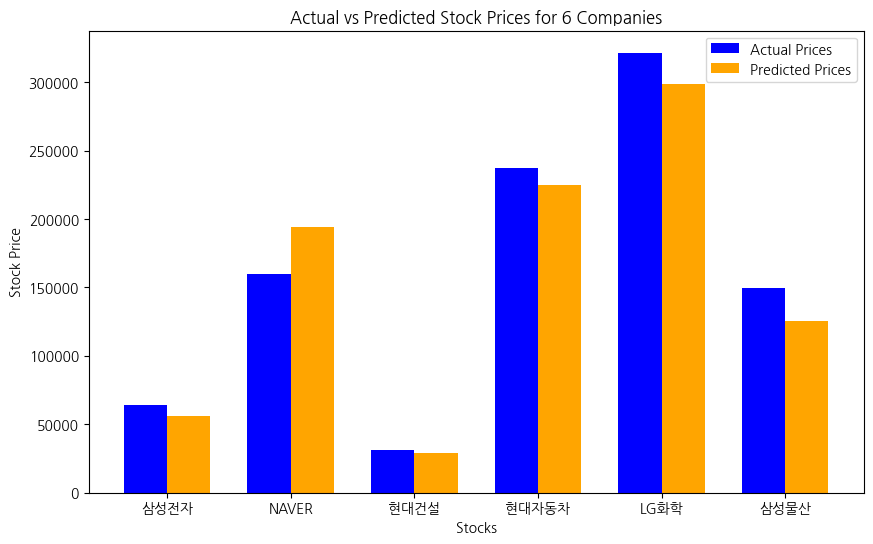

MAE: 17205.40
MSE: 410818023.94
R^2: 0.96


In [13]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from datetime import datetime, timedelta

# 한글 폰트 설정
plt.rcParams['font.family'] = 'NanumGothic'

# 실제 주가와 예측 주가 리스트
actual_prices = []  # 실제 주가 리스트
predicted_prices = []  # 예측된 주가 리스트

# 6개의 종목과 날짜에 대해 예측 수행
stocks = ["삼성전자", "NAVER", "현대건설", "현대자동차", "LG화학", "삼성물산"]
dates_input = ["2024-8-14", "2024-8-14", "2024-8-14", "2024-8-14", "2024-8-14", "2024-8-14"]

for stock_name, date in zip(stocks, dates_input):
    # 날짜 포맷 변환 (문자열 -> datetime 객체)
    date_obj = datetime.strptime(date, "%Y-%m-%d")

    # 한 달 뒤의 날짜 계산
    one_month_later = date_obj + timedelta(days=30)  # 30일 후로 간주

    # 한 달 뒤 날짜를 다시 문자열로 변환
    date_one_month_later = one_month_later.strftime("%Y-%m-%d")

    result = predict_stock_price_on_date(stock_name, date, merged_data, industry_weights)

    # 예측값과 실제값 리스트에 추가
    predicted_price = result["1개월 후 예상 주가"]

    # 실제 주가 가져오기: 1개월 뒤 날짜로 필터링
    actual_data = merged_data[(merged_data['ISU_NM'] == stock_name) & (merged_data['BAS_DD'] == date_one_month_later)]

    if not actual_data.empty:
        actual_price = actual_data['TDD_CLSPRC'].values[0]
    else:
        actual_price = np.nan  # 실제 데이터가 없으면 NaN 처리

    predicted_prices.append(predicted_price)
    actual_prices.append(actual_price)

# 시각화: 실제 주가와 예측 주가 비교
x = np.arange(len(stocks))  # x축 값 (종목 수)

# 막대 차트
plt.figure(figsize=(10, 6))

bar_width = 0.35  # 막대 너비
plt.bar(x - bar_width / 2, actual_prices, bar_width, label='Actual Prices', color='blue')
plt.bar(x + bar_width / 2, predicted_prices, bar_width, label='Predicted Prices', color='orange')

# 그래프 제목과 레이블 설정
plt.title('Actual vs Predicted Stock Prices for 6 Companies')
plt.xlabel('Stocks')
plt.ylabel('Stock Price')
plt.xticks(x, stocks)  # 종목 이름을 x축에 표시
plt.legend()

# 그래프 표시
plt.show()

# NaN 값 제외하고 정확도 평가
actual_prices_clean = [price for price in actual_prices if not np.isnan(price)]
predicted_prices_clean = [predicted_prices[i] for i in range(len(predicted_prices)) if not np.isnan(actual_prices[i])]

if len(actual_prices_clean) > 0:
    mae = mean_absolute_error(actual_prices_clean, predicted_prices_clean)
    mse = mean_squared_error(actual_prices_clean, predicted_prices_clean)
    r2 = r2_score(actual_prices_clean, predicted_prices_clean)

    print(f"MAE: {mae:.2f}")
    print(f"MSE: {mse:.2f}")
    print(f"R^2: {r2:.2f}")
else:
    print("실제 주가 데이터가 부족하여 정확도를 계산할 수 없습니다.")

**weighted_score**는 산업별 가중치를 반영하여 계산된 점수로, 각 기업의 재무 성과를 나타내는 종합적인 지표입니다. 이 값은 특정 기업의 재무 건전성, 성장성, 수익성 등을 반영하며, **다양한 재무 지표들(예: 영업이익률, ROE, 부채비율 등)**의 가중 평균으로 계산됩니다.

이 점수가 주가 예측에 큰 영향을 미친다는 것은, 기업의 종합적인 재무 상태가 주가 변동성을 예측하는 데 중요한 요소라는 것을 의미합니다.

In [32]:
# 특정 종목과 날짜로 예측 실행
result = predict_stock_price_on_date("삼성전자", "2024-11-15", merged_data,random_search.best_estimator_, industry_weights)
print(result)
result = predict_stock_price_on_date("NAVER", "2023-12-02", merged_data, random_search.best_estimator_, industry_weights)
print(result)
result = predict_stock_price_on_date("현대건설", "2024-10-01", merged_data, random_search.best_estimator_, industry_weights)
print(result)
result = predict_stock_price_on_date("현대자동차", "2023-07-01", merged_data, random_search.best_estimator_,  industry_weights)
print(result)
result = predict_stock_price_on_date("LG화학", "2024-08-21", merged_data, random_search.best_estimator_, industry_weights)
print(result)
result = predict_stock_price_on_date("삼성물산", "2022-05-20", merged_data, random_search.best_estimator_, industry_weights)
print(result)

{'종목명': '삼성전자', '예측 기준 날짜': '2024-11-15', '현재 주가': 53500, '재무지표 등락률': 0.023376512374000003, '1개월 후 예상 주가': 53598.20505938988}
{'종목명': 'NAVER', '예측 기준 날짜': '2023-12-02', '현재 주가': 206000, '재무지표 등락률': 0.23210530286300002, '1개월 후 예상 주가': 209440.8985007654}
{'종목명': '현대건설', '예측 기준 날짜': '2024-10-01', '현재 주가': 30500, '재무지표 등락률': 0.379594450565, '1개월 후 예상 주가': 31288.966866769053}
{'종목명': '현대자동차', '예측 기준 날짜': '2023-07-01', '현재 주가': 206500, '재무지표 등락률': 0.5412907094730001, '1개월 후 예상 주가': 213713.28948997328}
{'종목명': 'LG화학', '예측 기준 날짜': '2024-08-21', '현재 주가': 298000, '재무지표 등락률': -0.005524411207000003, '1개월 후 예상 주가': 297869.0098528308}
{'종목명': '삼성물산', '예측 기준 날짜': '2022-05-20', '현재 주가': 116500, '재무지표 등락률': 0.275986246042, '1개월 후 예상 주가': 118775.37247006137}


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does